Implementation of the FaSTM $\forall$ N algorithm, from the initial transaction data up to the community detection. It is implemented in a less efficient and scalable way than the code of the authors, but it is probably more transparent and understandable.

Repo of the paper: https://github.com/mhaseebtariq/fastman/tree/main

# Libraries and paths

In [25]:
import os
import igraph as ig
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Useful `polars` references:
- Python API reference: https://docs.pola.rs/api/python/stable/reference/index.html
- Getting started guide: https://docs.pola.rs/user-guide/getting-started/
- Key differences with `pandas`: https://docs.pola.rs/user-guide/migration/pandas/

In [11]:
# General location for the data
data_location = os.path.join("..", "data")

# Set location where we will save the partitions
partitions_location = os.path.join(data_location, 'partition')

# Create a location where we will save the joins
joins_location = os.path.join(data_location, "joins")

# Location of the nodes and the edges
nodes_location = os.path.join(data_location, "nodes")
edges_location = os.path.join(data_location, "edges")

# 0. Importing and preprocessing the transaction data

## Import

In [48]:
df = pl.read_csv(os.path.join(data_location, 'HI-Small_Trans.csv'))

In [49]:
df.head()

Timestamp,From Bank,Account,To Bank,Account_duplicated_0,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
str,i64,str,i64,str,f64,str,f64,str,str,i64
"""2022/09/01 00:20""",10,"""8000EBD30""",10,"""8000EBD30""",3697.34,"""US Dollar""",3697.34,"""US Dollar""","""Reinvestment""",0
"""2022/09/01 00:20""",3208,"""8000F4580""",1,"""8000F5340""",0.01,"""US Dollar""",0.01,"""US Dollar""","""Cheque""",0
"""2022/09/01 00:00""",3209,"""8000F4670""",3209,"""8000F4670""",14675.57,"""US Dollar""",14675.57,"""US Dollar""","""Reinvestment""",0
"""2022/09/01 00:02""",12,"""8000F5030""",12,"""8000F5030""",2806.97,"""US Dollar""",2806.97,"""US Dollar""","""Reinvestment""",0
"""2022/09/01 00:06""",10,"""8000F5200""",10,"""8000F5200""",36682.97,"""US Dollar""",36682.97,"""US Dollar""","""Reinvestment""",0


## Preprocessing

In [50]:
# Rename columns for clarity
df = df.rename(mapping = {"Account": "Source Account","Account_duplicated_0": "Destination Account"})

# Convert Timestamp to datetime type
df = df.with_columns(
    pl.col("Timestamp").str.strptime(pl.Datetime, format="%Y/%m/%d %H:%M")
)

df.head()

Timestamp,From Bank,Source Account,To Bank,Destination Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
datetime[μs],i64,str,i64,str,f64,str,f64,str,str,i64
2022-09-01 00:20:00,10,"""8000EBD30""",10,"""8000EBD30""",3697.34,"""US Dollar""",3697.34,"""US Dollar""","""Reinvestment""",0
2022-09-01 00:20:00,3208,"""8000F4580""",1,"""8000F5340""",0.01,"""US Dollar""",0.01,"""US Dollar""","""Cheque""",0
2022-09-01 00:00:00,3209,"""8000F4670""",3209,"""8000F4670""",14675.57,"""US Dollar""",14675.57,"""US Dollar""","""Reinvestment""",0
2022-09-01 00:02:00,12,"""8000F5030""",12,"""8000F5030""",2806.97,"""US Dollar""",2806.97,"""US Dollar""","""Reinvestment""",0
2022-09-01 00:06:00,10,"""8000F5200""",10,"""8000F5200""",36682.97,"""US Dollar""",36682.97,"""US Dollar""","""Reinvestment""",0


Note that polars' unit of time when converting a datetime column into the time passed since the 1st of January 1970 is microseconds: https://docs.pola.rs/api/python/stable/reference/api/polars.datatypes.Datetime.html

In [51]:
# Extract date and Unix timestamp (microseconds since 1970)
df = df.with_columns(
    df["Timestamp"].dt.date().alias("Date"),
    df["Timestamp"].cast(pl.Int64).alias("Microseconds_since_1970"),
)

# Convert microseconds since 1970 into seconds (by dividing by 10**6)
df = df.with_columns(
    (pl.col("Microseconds_since_1970") // 10**6).alias("Seconds_since_1970")
)

# Drop original microseconds column
df = df.drop(["Timestamp", "Microseconds_since_1970"])

df.head()

From Bank,Source Account,To Bank,Destination Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Date,Seconds_since_1970
i64,str,i64,str,f64,str,f64,str,str,i64,date,i64
10,"""8000EBD30""",10,"""8000EBD30""",3697.34,"""US Dollar""",3697.34,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661991600
3208,"""8000F4580""",1,"""8000F5340""",0.01,"""US Dollar""",0.01,"""US Dollar""","""Cheque""",0,2022-09-01,1661991600
3209,"""8000F4670""",3209,"""8000F4670""",14675.57,"""US Dollar""",14675.57,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990400
12,"""8000F5030""",12,"""8000F5030""",2806.97,"""US Dollar""",2806.97,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990520
10,"""8000F5200""",10,"""8000F5200""",36682.97,"""US Dollar""",36682.97,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990760


In this graph, each row is a transaction. Note, however, that there is one requirement of the data that must be created for running the FaSTM $\forall$ N algorithm_ a unique identifier for a transaction. We can create this unique identifier just from the current index.

In [52]:
df = df.with_row_index(name="Transaction_id", offset=1)  # Start IDs from 1

df.head()

Transaction_id,From Bank,Source Account,To Bank,Destination Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Date,Seconds_since_1970
u32,i64,str,i64,str,f64,str,f64,str,str,i64,date,i64
1,10,"""8000EBD30""",10,"""8000EBD30""",3697.34,"""US Dollar""",3697.34,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661991600
2,3208,"""8000F4580""",1,"""8000F5340""",0.01,"""US Dollar""",0.01,"""US Dollar""","""Cheque""",0,2022-09-01,1661991600
3,3209,"""8000F4670""",3209,"""8000F4670""",14675.57,"""US Dollar""",14675.57,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990400
4,12,"""8000F5030""",12,"""8000F5030""",2806.97,"""US Dollar""",2806.97,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990520
5,10,"""8000F5200""",10,"""8000F5200""",36682.97,"""US Dollar""",36682.97,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990760


## Partitioning the data by days of the transaction

For the first step of the FaSTM $\forall$ N, we need to do a Cartesian product of rows in a time window of 1 day (as in the paper, they state that "The transactions are processed iteratively, one day at a time"), which can exponentially increase the number of rows and not fit in the memory. To that end, below we partition the dataset using the `polars` method `write_parquet`, which creates a "hive partitioned parquet dataset" according to the specified column (https://docs.pola.rs/user-guide/io/hive/#writing-hive-partitioned-data).

In [ ]:
# Write Hive-partitioned Parquet files
df.write_parquet(
    partitions_location,
    partition_by=["Date"],  # Partition by this column
) 

Example of reading the hived dataset using polars (https://docs.pola.rs/user-guide/io/hive/#scanning-hive-partitioned-data):

In [54]:
df = pl.scan_parquet(partitions_location).collect()

df.head()

Transaction_id,From Bank,Source Account,To Bank,Destination Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Date,Seconds_since_1970
u32,i64,str,i64,str,f64,str,f64,str,str,i64,date,i64
1,10,"""8000EBD30""",10,"""8000EBD30""",3697.34,"""US Dollar""",3697.34,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661991600
2,3208,"""8000F4580""",1,"""8000F5340""",0.01,"""US Dollar""",0.01,"""US Dollar""","""Cheque""",0,2022-09-01,1661991600
3,3209,"""8000F4670""",3209,"""8000F4670""",14675.57,"""US Dollar""",14675.57,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990400
4,12,"""8000F5030""",12,"""8000F5030""",2806.97,"""US Dollar""",2806.97,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990520
5,10,"""8000F5200""",10,"""8000F5200""",36682.97,"""US Dollar""",36682.97,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990760


This is just the initial dataset, but read from a partitioned structure!

In [59]:
# Remove the data frame for memory efficiency
del df

# 1. Temporal graph creation ("Temporal Graph of Sequential Transactions")

## 1.1. Set FaSTM $\forall$ N parameters

In [9]:
# Time window in days
window = 2
# Minimum edge of the weights for considering them
min_edge_weights = 0.5

## 1.2. Sequential inner joins

Now, we will iterate over the different transaction dates that we have in our dataset (ensures that at any point we only load a manageable subset of the data into memory). The code below implements the **Definition 1** in Tariq and Hassani (2024), together with pages 7 and 8 of their paper. Guideline of the operations done below:

1. **Partition Discovery:**  The code begins by listing all subdirectories under the `partition` folder and extracting the dates. This allows us to work one day at a time (or over a window of days).

2. **Window Definition:** For each transaction date, a window is defined (for example, the current day plus one extra day). This "extra" is set by the `window` parameter ($\Delta w$), which is not disclosed by the authors (they only state that they use a "very consdervative *undisclosed* value for $\Delta w$). Only partitions (files) within this window are read. Note that by increasing this parameter, the number of inner joins will significantly increase.

3. **Lazy Scanning:** For keeping the memory footprint low, we use `pl.scan_parquet` on only the necessary partitions to ensure that we are not reading the whole dataset within the time window. In lazy mode nothing is executed (i.e., the dataset is not materialized) until we call `collect()`. See: https://docs.pola.rs/api/python/stable/reference/lazyframe/api/polars.LazyFrame.collect.html#polars.LazyFrame.collect

4. **Filtering and Splitting Data:** The same lazy DataFrame is used to define both “right” and “left” subsets. The left subset is filtered further by a timestamp criterion (e.g. rows with `Timestamp` less than the maximum timestamp of the current date). Here, the "left" subset will contain the source edges $s$, while the "right" subset will contain the destination edges $d$ (see definition 1 in the paper).

5. **Renaming Columns:** To avoid collisions during the join, all columns in the left subset are renamed by appending a suffix.

6. **Joining and Calculating Time Delta:**
   - An inner join is then performed based on the desired key: we join “Destination Account_left” from the left side (i.e., the beneficiary of the source node, $b_s$) to a “Source Account” from the right side (the "from" account in the destination transaction, $f_d$).
   - After the join, a new column “delta” is calculated (as the difference between timestamps) and filtered so that only positive deltas are kept (i.e., we only keep those "right" transactions which happen after the "left").

7. **Collecting with Streaming:**  
   - The final lazy query is executed with `collect(streaming=True)`, which instructs Polars to process data in batches rather than all at once—helping to keep memory usage low (https://docs.pola.rs/user-guide/concepts/_streaming/).  
   - The batch size can be adjusted: see https://docs.pola.rs/api/python/dev/reference/api/polars.Config.set_streaming_chunk_size.html.

8. **Output:** The joined result is written out to disk as a parquet file under a directory named for the current staging date.

In [4]:
# We get a sorted list of transaction dates from the partition directories.
all_partitions = os.listdir(partitions_location)
dates = sorted([
    partition.split("=")[1] 
    for partition in all_partitions 
    if partition.startswith("Date=")  # Note that the partition directories start with "Date=" (the column where we stored the date above)
])

print(dates)

['2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04', '2022-09-05', '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16', '2022-09-17', '2022-09-18']


In [ ]:
total_rows_joined_dataset = 0

for transaction_date in dates:

    # Define the start date (window start) for filtering right partitions
    current_date = datetime.strptime(transaction_date, "%Y-%m-%d")
    # Define the end date (window end) for filtering right partitions
    end_date = current_date + timedelta(days=window)
    end_date_str = end_date.strftime("%Y-%m-%d")  # Convert end date to string
    
    # Determine which partitions fall in the window: dates between current_date and end_date, inclusive
    window_dates = [d for d in dates if transaction_date <= d <= end_date_str]
    
    # Build the file paths for these partitions
    right_paths = [
        os.path.join(partitions_location, f"Date={d}")
        for d in window_dates
    ]
    
    # Read the "right" side data lazily from only the required partitions
    right = pl.scan_parquet(right_paths)
    
    # Define a maximum timestamp for the current date (e.g., all transactions with
    # a timestamp less than the end of the day)
    max_ts_time = datetime.combine(current_date, datetime.max.time())
    max_ts = max_ts_time.timestamp()  # Convert to a timestamp
    
    # Filter the "left" side: only rows from the window with Timestamp before max_ts
    left = right.filter(pl.col("Seconds_since_1970") < max_ts)
    
    # Rename the columns in the left DataFrame so that after the join left and right have distinct names
    left = left.rename({col: f"{col}_left" for col in left.columns})
    
    # Create the right join key to preserve the original source account (just a "trick")
    # However, note that the right source account should match to the left destination
    # account
    right = right.with_columns(pl.col("Source Account").alias("Source Account_right"))

    # Perform the inner join on the left and right data frames
    join_expr = left.join(
        right, 
        left_on="Destination Account_left",  # Destination account of the left data frame
        right_on="Source Account_right",  # Source account of the right data frame
        how="inner"
    )
    
    # Calculate the time delta between the joined timestamps
    join_expr = join_expr.with_columns(
        (pl.col("Seconds_since_1970") - pl.col("Seconds_since_1970_left")).alias("delta")
    )
    
    # Only keep rows where the delta is positive (right transaction happens after left)
    join_expr = join_expr.filter(pl.col("delta") > 0)
    
    # Use streaming mode (if supported) to keep the memory footprint low.
    # The lazy query will process data in batches.
    join_df = join_expr.collect(streaming=True)
    
    # Write out the result for the current transaction_date, partitioning the results
    # by the transaction_date
    
    join_df = join_df.with_columns(
        pl.lit(transaction_date).alias("staging_date"))  # Add the staging date as a column
    
    join_df.write_parquet(
        joins_location,
        partition_by=["staging_date"],  # Partition by the staging column
    ) 

    total_rows_joined_dataset += join_df.height
    print(f"Processed transaction_date {transaction_date} with {join_df.height} joined rows.")

print(f'Total rows of the joined data frame: {total_rows_joined_dataset}')

/tmp/ipykernel_84608/4239545022.py:32: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  left = left.rename({col: f"{col}_left" for col in left.columns})
/tmp/ipykernel_84608/4239545022.py:55: DeprecationWarning: The argument `streaming=True` is deprecated and is being replaced by the `engine` argument.
  join_df = join_expr.collect(streaming=True)
/tmp/ipykernel_84608/4239545022.py:55: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/

Processed transaction_date 2022-09-01 with 4762412 joined rows.
Processed transaction_date 2022-09-02 with 23498285 joined rows.
Processed transaction_date 2022-09-03 with 592423 joined rows.
Processed transaction_date 2022-09-04 with 798971 joined rows.
Processed transaction_date 2022-09-05 with 2152970 joined rows.
Processed transaction_date 2022-09-06 with 2157398 joined rows.
Processed transaction_date 2022-09-07 with 2327036 joined rows.
Processed transaction_date 2022-09-08 with 1822694 joined rows.
Processed transaction_date 2022-09-09 with 15645442 joined rows.
Processed transaction_date 2022-09-10 with 85011 joined rows.
Processed transaction_date 2022-09-11 with 547 joined rows.
Processed transaction_date 2022-09-12 with 496 joined rows.
Processed transaction_date 2022-09-13 with 440 joined rows.
Processed transaction_date 2022-09-14 with 273 joined rows.
Processed transaction_date 2022-09-15 with 148 joined rows.
Processed transaction_date 2022-09-16 with 106 joined rows.
Pr

Note that, depending on the amount of RAM of your computer, you will not be able to read the whole data frame (there are more than 50M rows and 13 * 2 + 1 columns, with $\Delta w = 2$)! For that reason, below we only read one parquet file as an example.

In [19]:
# Read the final results
df_joins_2022_09_01 = pl.read_parquet(os.path.join(joins_location, "staging_date=2022-09-01/00000000.parquet"))

df_joins_2022_09_01.head()

Transaction_id_left,From Bank_left,Source Account_left,To Bank_left,Destination Account_left,Amount Received_left,Receiving Currency_left,Amount Paid_left,Payment Currency_left,Payment Format_left,Is Laundering_left,Date_left,Seconds_since_1970_left,Transaction_id,From Bank,Source Account,To Bank,Destination Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Date,Seconds_since_1970,delta,staging_date
u32,i64,str,i64,str,f64,str,f64,str,str,i64,date,i64,u32,i64,str,i64,str,f64,str,f64,str,str,i64,date,i64,i64,str
280626,12,"""8000F5030""",12,"""8000F5030""",616552.72,"""Brazil Real""",109192.02,"""US Dollar""","""ACH""",0,2022-09-01,1661990400,4,12,"""8000F5030""",12,"""8000F5030""",2806.97,"""US Dollar""",2806.97,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990520,120,"""2022-09-01"""
30134,11107,"""803C662C0""",1,"""8000F5AD0""",0.62,"""US Dollar""",0.62,"""US Dollar""","""Credit Card""",0,2022-09-01,1661990460,6,1,"""8000F5AD0""",1,"""8000F5AD0""",6162.44,"""US Dollar""",6162.44,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990580,120,"""2022-09-01"""
94949,2952,"""80F7CE4C0""",1,"""8000EC1E0""",128.9,"""US Dollar""",128.9,"""US Dollar""","""Credit Card""",0,2022-09-01,1661991060,8,1,"""8000EC1E0""",1,"""8000EC1E0""",11.86,"""US Dollar""",11.86,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661991360,300,"""2022-09-01"""
97149,1244,"""80FFE9B00""",1,"""80012FE50""",26.31,"""US Dollar""",26.31,"""US Dollar""","""Credit Card""",0,2022-09-01,1661990700,16,1,"""80012FE50""",1,"""80012FE50""",3.9442e6,"""US Dollar""",3.9442e6,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990940,240,"""2022-09-01"""
24,1665,"""8005E18F0""",1665,"""8005E18F0""",9.89,"""US Dollar""",9.89,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661990520,19,1665,"""8005E18F0""",1665,"""8005E18F0""",157.57,"""US Dollar""",157.57,"""US Dollar""","""Reinvestment""",0,2022-09-01,1661992080,1560,"""2022-09-01"""


Note that we should convert all of the amounts to a common currency, such as US dollars, so that the amount paid matches the amount received. This will simplify and make the computations below consistent.

## 1.3. Creating the nodes and edges

Now we have made all of the inner joins sequentially, as described by the algorithm. The next step is to construct the graph itself, following the **definition 1** in the paper. The idea below is to construct the `igraph` graph incrementally by adding vertices/edges per partition.

### Node construction

Each node will be a unique transaction. We will process the nodes incrementally by using the partitioned data so that, again, the memory is not overloaded.

In [21]:
# Get list of join partitions
join_partitions = [
    os.path.join(joins_location, p) 
    for p in os.listdir(joins_location) 
    if p.startswith("staging_date=")
]

# Initialize graph
g = ig.Graph(directed=True)

# Process each partition incrementally
for join_partition in join_partitions:
    # Read join data for this partition
    df_join = pl.scan_parquet(os.path.join(join_partition, "*.parquet")).collect()
    
    # Process nodes (left side)
    nodes_left = df_join.select([
        pl.col("Transaction_id_left").alias("id"),
        pl.col("Source Account_left").alias("source"),
        pl.col("Destination Account_left").alias("target"),
        pl.col("Seconds_since_1970_left").alias("transaction_timestamp"),
        pl.col("Amount Paid_left").alias("amount"),
        pl.col("Date_left").alias("transaction_date"),
        pl.col("Is Laundering_left").alias("is_laundering")
    ]).unique("id")  # Select only those with unique IDs

    # Process nodes (right side)
    nodes_right = df_join.select([
        pl.col("Transaction_id").alias("id"),
        pl.col("Source Account").alias("source"),
        pl.col("Destination Account").alias("target"),
        pl.col("Seconds_since_1970").alias("transaction_timestamp"),
        pl.col("Amount Paid").alias("amount"),
        pl.col("Date").alias("transaction_date"),
        pl.col("Is Laundering").alias("is_laundering")
    ]).unique("id")  # Select only those with unique IDs
    
    # Combine and deduplicate
    nodes_partition = pl.concat([nodes_left, nodes_right]).unique("id")
    
    # Write nodes partition
    nodes_partition.write_parquet(
        nodes_location,
        partition_by="transaction_date"
    )
    
    # Add to graph incrementally
    g.add_vertices(nodes_partition["id"].to_list())

### Edge construction

Again, we will construct the edges incrementally.

In [22]:
# Process edges incrementally
for join_partition in join_partitions:
    df_join = pl.scan_parquet(os.path.join(join_partition, "*.parquet")).collect()
    
    # Create edges
    edges_partition = df_join.select([
        pl.col("Transaction_id_left").alias("src"),  # Use the left transaction ID as the source
        pl.col("Transaction_id").alias("dst"),  # Use the right transaction ID as the destination
        pl.col("Date_left").alias("src_date"),
        pl.col("Date").alias("dst_date")
    ])
    
    # Write edges partition
    edges_partition.write_parquet(
        edges_location,
        partition_by=["src_date", "dst_date"]
    )
    
    # Add edges to graph
    g.add_edges(zip(
        edges_partition["src"].to_list(),
        edges_partition["dst"].to_list()
    ))

### Graph visualization

Since the graph is immense, below we only plot a subset of the transactions.

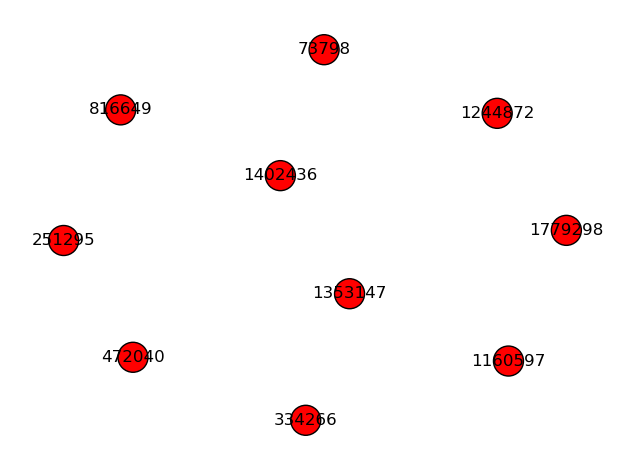

In [35]:
# Select nodes
selected_node_ids = list(range(1, 11))  # Select the first 50 nodes

# Create the subgraph
subgraph = g.subgraph(selected_node_ids)

# Create a default color for all nodes with transparency with RGBA (e.g., light gray with alpha=0.2)
colors = [(0.5, 0.5, 0.5, 0.1)] * subgraph.vcount()

# degrees = subgraph.degree()  # Compute degrees of nodes

# # Normalize node sizes (optional: adjust scale factor)
# min_size, max_size = 20, 60  # Adjust as needed
# vertex_sizes = [min_size + (max_size - min_size) * (deg / max(degrees)) for deg in degrees]

layout = subgraph.layout("fr")  # Fruchterman-Reingold layout

# Scale the layout to spread out the nodes
layout.scale(5)  # Adjust the scaling factor

# Plot the graph with the specified vertex colors
fig, ax = plt.subplots()
ig.plot(
    subgraph,
    layout=layout,
    vertex_size=30,
    vertex_label=subgraph.vs["name"],
    edge_width=0.5,
    bbox=(800, 600),
    target=ax,
)
plt.tight_layout()
plt.savefig("figures/fastman_initial_graph", dpi = 300)
plt.show()

## 2. 2nd Order Graph Creation

In this section, we derive  the 2nd order graph of sequential transactions in order to impute the edge weights to the graph in the previous section.